### Callback API
- 모델이 학습 중에 충돌이 발생하거나 네트워크가 끊기면, 모든 훈련 시간이 낭비될 수 있고, 과적합을 방지하기 위해 훈련을 중간에 중지해야 할 수도 있다.
- 모델이 학습을 시작하면 학습이 완료될 때까지 아무런 제어를 하지 못하게 되고,  
신경망 훈련을 완료하는 데는 몇 시간 또는 며칠이 걸릴 수 있기 때문에 모델을 모니터링하고 제어할 수 있는 기능이 필요하다.
- 훈련 시(fit) Callback API를 등록 시키면 반복 내에서 특정 이벤트 발생 시마다 등록된 callback이 호출되어 수행된다.

#### ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
특정 조건에 따라 모델을 파일로 저장한다.
- filepath: "weights.{epoch:03d}-{val_loss:.4f}.hdf5" 와 같이 파일 이름에 반복 회차와 검증 손실을 작성하여 모델의 체크포인트를 저장한다.
- monitor: 모니터링할 성능 지표를 작성한다 (loss 또는 평가 지표).
- save_best_only: 가장 좋은 성능을 나타내는 모델을 저장할 지에 대한 여부
- save_weights_only: weights만 저장할 지에 대한 여부
- mode: {auto, min, max} 중 하나. monitor 성능 지표가 감소해야 좋을 경우 min, 증가해야 좋을 경우 max, auto는 monitor 이름에서 자동으로 유추한다.

#### ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_lr=0)
특정 반복 동안 성능이 개선되지 않을 때, 학습률(Learning rate)를 동적으로 감소시킨다.
- monitor: 모니터링할 성능 지표를 작성한다 (loss 또는 평가 지표).
- factor: 학습률을 감소 시킬 비율. 새로운 학습률 = 기존 학습률 * factor 
- patience: 학습률을 줄이기 전에 monitor할 반복 횟수. 
- mode: {auto, min, max} 중 하나. monitor 성능 지표가 감소해야 좋을 경우 min, 증가해야 좋을 경우 max, auto는 monitor 이름에서 자동으로 유추한다.

#### EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
특정 반복 동안 성능이 개선되지 않을 때, 학습을 조기에 중단한다.
- monitor: 모니터링할 성능 지표를 작성한다 (loss 또는 평가 지표).
- patience: Early Stopping을 적용하기 전에 monitor할 반복 횟수. 
- mode: {auto, min, max} 중 하나. monitor 성능 지표가 감소해야 좋을 경우 min, 증가해야 좋을 경우 max, auto는 monitor 이름에서 자동으로 유추한다.

In [1]:
from tensorflow.keras.layers import Layer, Input, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

INPUT_SIZE = 28

def create_model():
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs = input_tensor, outputs = output)
    return model

In [2]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)
    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, valid_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)
    
    train_train_images, validation_images, train_train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=valid_size, random_state=random_state)

    return (train_train_images, train_train_oh_targets), (validation_images, validation_oh_targets),(test_images, test_oh_targets)

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_targets), (test_images, test_targets) = fashion_mnist.load_data()
print(train_images.shape, train_targets.shape, test_images.shape, test_targets.shape)

(train_train_images, train_train_oh_targets), (validation_images, validation_oh_targets),(test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_targets, test_images, test_targets)
print(train_train_images.shape, train_train_oh_targets.shape, validation_images.shape, validation_oh_targets.shape, test_images.shape, test_oh_targets.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(48000, 28, 28) (48000, 10) (12000, 28, 28) (12000, 10) (10000, 28, 28) (10000, 10)


##### ModelCheckPoint

In [8]:
!dir callback_files

 D 드라이브의 볼륨: 새 볼륨
 볼륨 일련 번호: 02B1-19A2

 D:\kdt_0900_hds\ai\deep-learning\c_Tensorflow\callback_files 디렉터리

2023-11-08  오전 09:50    <DIR>          .
2023-11-08  오전 09:50    <DIR>          ..
2023-11-08  오전 09:49           257,112 weights.001-0.4127.h5
2023-11-08  오전 09:49           257,112 weights.002-0.3770.h5
2023-11-08  오전 09:50           257,112 weights.003-0.3733.h5
2023-11-08  오전 09:50           257,112 weights.004-0.3498.h5
2023-11-08  오전 09:50           257,112 weights.005-0.3413.h5
2023-11-08  오전 09:50           257,112 weights.006-0.3260.h5
2023-11-08  오전 09:50           257,112 weights.009-0.3212.h5
               7개 파일           1,799,784 바이트
               2개 디렉터리  463,465,644,032 바이트 남음


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint

model = create_model()
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min', 
    verbose=1)

history = model.fit(x=train_train_images, y=train_train_oh_targets, batch_size=32, epochs=10, validation_data=(validation_images, validation_oh_targets), callbacks=[mcp_cb])

Epoch 1/10
1492/1500 [============================>.] - ETA: 0s - loss: 0.5295 - acc: 0.8112
Epoch 1: val_loss improved from inf to 0.41273, saving model to ./callback_files\weights.001-0.4127.h5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5288 - acc: 0.8114 - val_loss: 0.4127 - val_acc: 0.8519
Epoch 2/10
1480/1500 [============================>.] - ETA: 0s - loss: 0.3857 - acc: 0.8590
Epoch 2: val_loss improved from 0.41273 to 0.37699, saving model to ./callback_files\weights.002-0.3770.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3858 - acc: 0.8590 - val_loss: 0.3770 - val_acc: 0.8588
Epoch 3/10
1468/1500 [============================>.] - ETA: 0s - loss: 0.3500 - acc: 0.8723
Epoch 3: val_loss improved from 0.37699 to 0.37334, saving model to ./callback_files\weights.003-0.3733.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3502 - acc: 0.8721 - val_loss: 0.3733 - val_acc: 0.8585
Epoch 4/10
1492/1500 [=============

In [9]:
model.load_weights('./callback_files/weights.009-0.3212.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 59850 (233.79 KB)
Trainable params: 59850 (233.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### ReduceLROnPlateau

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model = create_model()
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=2, 
    mode='min', 
    verbose=1)

history = model.fit(x=train_train_images, y=train_train_oh_targets, batch_size=32, epochs=30, validation_data=(validation_images, validation_oh_targets), callbacks=[rlr_cb])

Epoch 1/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5228 - acc: 0.8126 - val_loss: 0.4020 - val_acc: 0.8532 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3851 - acc: 0.8602 - val_loss: 0.3797 - val_acc: 0.8566 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3464 - acc: 0.8736 - val_loss: 0.3470 - val_acc: 0.8724 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3241 - acc: 0.8813 - val_loss: 0.3243 - val_acc: 0.8784 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3063 - acc: 0.8861 - val_loss: 0.3432 - val_acc: 0.8738 - lr: 0.0010
Epoch 6/30
1480/1500 [============================>.] - ETA: 0s - loss: 0.2921 - acc: 0.8915
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2919 - acc: 0.8918 - val_los

##### EarlyStopping

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

ely_cb = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    mode='min', 
    verbose=1)

history = model.fit(x=train_train_images, y=train_train_oh_targets, batch_size=32, epochs=30, validation_data=(validation_images, validation_oh_targets), callbacks=[ely_cb])

Epoch 1/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5148 - acc: 0.8170 - val_loss: 0.4065 - val_acc: 0.8480
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3811 - acc: 0.8613 - val_loss: 0.3788 - val_acc: 0.8561
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3453 - acc: 0.8746 - val_loss: 0.3565 - val_acc: 0.8668
Epoch 4/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3201 - acc: 0.8824 - val_loss: 0.3538 - val_acc: 0.8694
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3015 - acc: 0.8875 - val_loss: 0.3496 - val_acc: 0.8677
Epoch 6/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2861 - acc: 0.8929 - val_loss: 0.3392 - val_acc: 0.8764
Epoch 7/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2745 - acc: 0.8966 - val_loss: 0.3201 - val_acc: 0.8812
Epoch 8/30
1500/1500 [==============================] - 3s 2ms

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min', 
    verbose=1)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=2, 
    mode='min', 
    verbose=1)

ely_cb = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    mode='min', 
    verbose=1)

history = model.fit(x=train_train_images, y=train_train_oh_targets, batch_size=32, epochs=30, validation_data=(validation_images, validation_oh_targets), callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/30
1471/1500 [============================>.] - ETA: 0s - loss: 0.5228 - acc: 0.8141
Epoch 1: val_loss improved from inf to 0.41983, saving model to ./callback_files\weights.001-0.4198.h5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5203 - acc: 0.8150 - val_loss: 0.4198 - val_acc: 0.8451 - lr: 0.0010
Epoch 2/30
1489/1500 [============================>.] - ETA: 0s - loss: 0.3834 - acc: 0.8614
Epoch 2: val_loss improved from 0.41983 to 0.38148, saving model to ./callback_files\weights.002-0.3815.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3832 - acc: 0.8615 - val_loss: 0.3815 - val_acc: 0.8579 - lr: 0.0010
Epoch 3/30
1490/1500 [============================>.] - ETA: 0s - loss: 0.3464 - acc: 0.8737
Epoch 3: val_loss improved from 0.38148 to 0.35598, saving model to ./callback_files\weights.003-0.3560.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3460 - acc: 0.8738 - val_loss: 0.3560 - val_acc: 0.8662 - lr: 0.0

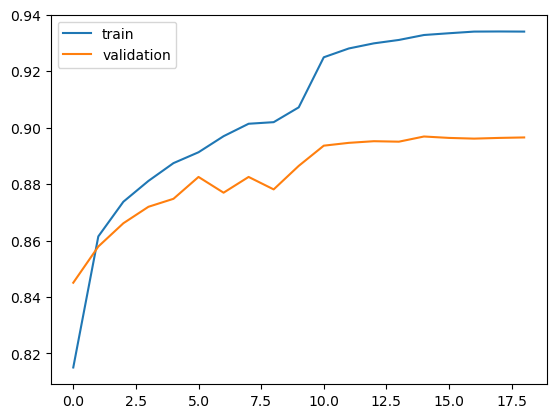

In [15]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()

show_history(history)

In [17]:
model.evaluate(test_images, test_oh_targets, batch_size=32)

313/313 [==============================] - 0s 1ms/step - loss: 0.3250 - acc: 0.8907


[0.3249518871307373, 0.8906999826431274]

In [ ]:
pred_proba = model.predict(np.expand_dims(test_images[124], axis=0))
print('softmax output:', pred_proba)
pred = np.argmax(np.squeeze(pred_proba))
print('predicted target value:', pred)

In [ ]:
import matplotlib.pyplot as plt

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.imshow(test_images[124], cmap='gray')
plt.title(class_names[int(test_targets[124])])